# Skip-gram Word2Vec

在此 notebook 中，我将讲解如何在 PyTorch 中使用 skip-gram 结构实现 [Word2Vec 算法](https://en.wikipedia.org/wiki/Word2vec)。我们将学习自然语言处理中用到的词嵌入概念。词嵌入对于机器翻译来说很有用。

## 扩展阅读

我在构建此 notebook 时参考了以下资料。建议提前阅读或在做练习的过程中参考这些资料。

* Word2Vec 的[概念介绍](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)，作者：Chris McCormick 
* Mikolov 等人的[第一篇 Word2Vec 论文](https://arxiv.org/pdf/1301.3781.pdf)。
* [神经信息处理系统](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)论文（对 Word2Vec 进行了改进），作者也是 Mikolov 等人。

---
## 词嵌入

在处理文本中的字词时，我们需要分析数千个字词类别；词汇表中的每个字词对应一个类别。对这些字词进行独热编码效率很低，因为独热向量中的大多数值将为 0。如果对独热输入向量与第一个隐藏层进行矩阵乘法运算，结果将生成一个有多个值为 0 的隐藏输出向量。

为了解决这个问题并提高网络的效率，我们将使用**嵌入**功能。嵌入其实就是全连接层，和你之前看过的层级一样。我们将此层级称为嵌入层，将权重称为嵌入权重。我们将跳过与嵌入层的乘法运算步骤，直接从权重矩阵里获取隐藏层的值。这是因为独热向量与矩阵相乘后，结果是“开启”输入单元的索引对应的矩阵行。

<img src='assets/lookup_matrix.png' width=50%>

我们将使用权重矩阵作为查询表，而不是执行矩阵乘法运算。我们用整数表示字词，例如用 958 表示“heart”，用 18094 表示“mind”。要获取“heart”的隐藏层值，直接从嵌入矩阵里获取第 958 行的值。这个流程称为**嵌入查询**，隐藏单元的数量称为**嵌入维度**。
 
其实没什么神奇之处。嵌入查询表只是权重矩阵。嵌入层只是隐藏层。查询是矩阵乘法的便捷运算。我们像训练任何其他权重矩阵一样训练查询表。

当然，嵌入并不是仅适用于字词。它们可以用于任何类别数量庞大的模型。有一种特殊的模型叫做 **Word2Vec**，它使用嵌入层查找包含特定语义信息的向量表示法。

---
## Word2Vec

Word2Vec 算法通过查找表示字词的向量，得出更高效的表示法。这些向量也包含关于字词的语义信息。

<img src="assets/context_drink.png" width=40%>

出现在相似**上下文**里的字词将具有相互靠近的向量，例如“coffee”、“tea”和“water”。不同字词的向量相互之间离得更远，在向量空间里的距离可以表示字词之间的关系。


Word2Vec 有两种实现结构：
>* CBOW（连续词袋模型），以及 
* Skip-gram

<img src="assets/word2vec_architectures.png" width=60%>

在此 notebook 中，我们将使用 **skip-gram 结构**和**负采样**，因为 skip-gram 的效果比 CBOW 好，并且负采样的训练速度更快。对于 skip-gram 结构，我们将传入一个字词，并尝试预测它在文本里的上下文字词。这样我们便能训练网络学习出现在相似上下文里的字词的表示法。

---
## 加载数据

下面请加载数据并将其放入 `data` 目录中

1.加载 [text8 数据集](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip)；它是一个经过清理的*维基百科文章*文本文件，该文件由 Matt Mahoney 提供。 
2.将数据放入主目录中的 `data` 文件夹下。
3.然后解压 ZIP 文件并删除 ZIP 文件以释放存储空间。

完成这些步骤之后，数据目录中应该只有`data/text8` 这个文件。

In [1]:
# read in the extracted text file      
with open('data/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## 预处理

我将预处理文本，使训练流程更方便。打开 `utils.py` 文件。其中的 `preprocess` 函数将执行以下几个操作：
>* 将所有标点转换为标记，因此“.”变成 ` <PERIOD> `。虽然此数据集没有任何标点，但是这一步对其他 NLP 问题来说很有用。 
* 删除在数据集中出现次数不超过 5 次的字词。这样能够显著减少数据噪点带来的问题，并且能够改善向量表示法的质量。 
* 返回由文本中的一些字词构成的列表。

由于文本文件很庞大，所以运行时间可能较长。如果你想自己编写一个函数，就尽管尝试吧！

In [2]:
import utils

# get list of words
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [3]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


### 字典

下面我将创建两个字典，一个将字词转换为整数，另一个将整数转换为字词。同样在 `utils.py` 文件里使用一个函数完成这个步骤。`create_lookup_tables` 的输入参数是一个文本字词列表，并返回两个字典。
>* 按照频率降序分配整数，最常见的字词“the”对应的整数是 0，第二常见的字词是 1，以此类推。 

创建好字典后，将字词转换为整数并存储在 `int_words` 列表中。

In [4]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## 二次采样

“the”、“of”和“for”等经常出现的字词并不能为附近的字词提供很多上下文信息。如果丢弃某些常见字词，则能消除数据中的一些噪点，并提高训练速度和改善表示法的质量。Mikolov 将这个流程称为二次采样。对于训练集中的每个字词 $w_i$，我们将根据某个概率丢弃该字词，公式为： 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

其中 $t$ 是阈值参数，$f(w_i)$ 是字词 $w_i$ 在总数据集中的频率。

> 对 `int_words` 中的字词进行二次采样。即访问 `int_words` 并根据上面所示的概率 $P(w_i)$ 丢弃每个字词。注意，$P(w_i)$ 表示丢弃某个字词的概率。将二次采样的数据赋值给 `train_words`。

In [5]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[5233, 3080, 45, 10571, 27349, 102, 854, 15067, 58112, 3580, 10712, 1324, 2731, 3672, 708, 371, 1423, 7088, 5233, 320, 44611, 2877, 5233, 2621, 8983, 59, 6437, 4186, 5233, 1818]


## 创建批次

准备好数据后，我们需要批处理数据，然后才能传入网络中。在使用 skip-gram 结构时，对于文本中的每个字词，我们都需要定义上下文窗口（大小为 $C$），然后获取窗口中的所有字词。 

摘自 [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf)： 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples...If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1:C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **练习：**请实现函数 `get_target`，输入参数为字词列表、索引和窗口大小，然后返回该索引所在窗口中的字词列表。请使用上面定义的算法，即从窗口里选择随机数量的字词。

假设有一段输入文本，并且我们对 idx=2 处的标记 `741` 感兴趣：

[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]

如果 `R=2`，`get_target` 应该返回有 4 个值的列表：

[5233, 58, 10571, 27349]

In [6]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [7]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [1, 2, 3, 4, 6, 7, 8, 9]


### 生成批次数据 

下面的生成器函数将使用上述 `get_target` 函数返回多批输入和目标数据。它会从字词列表中获取 `batch_size` 个字词。对于每批数据，它都会获取窗口中的目标上下文字词。

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [9]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 0, 2, 3, 0, 1, 3, 0, 1, 2]


---
## 验证

下面创建一个函数，它会在模型学习过程中观察模型。我们将选择一些常见字词和不常见字词。然后使用相似性余弦输出最靠近的字词。 

<img src="assets/two_vectors.png" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


我们使用嵌入表将验证字词表示为向量 $\vec{a}$，然后计算与嵌入表中每个字词向量 $\vec{b}$ 之间的相似程度。算出相似程度后，我们将输出验证字词以及嵌入表中与这些字词语义相似的字词。这样便于我们检查嵌入表是否将语义相似的字词组合到一起。

In [10]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

---
# SkipGram 模型

定义并训练 SkipGram 模型。 
> 你需要定义一个[嵌入层](https://pytorch.org/docs/stable/nn.html#embedding)和一个最终 softmax 输出层。

嵌入层有多个参数，最重要的是：
* **num_embeddings** – 嵌入字典的大小，即嵌入权重矩阵的行数
* **embedding_dim** – 每个嵌入向量的大小，即嵌入维度

下面是网络的大致示意图。
<img src="assets/skip_gram_arch.png" width=60%>

>* 输入字词以多批输入字词标记的形式传入网络中。 
* 这些输入字词将进入一个由线性单元组成的隐藏层（即嵌入层）。 
* 最后是一个 softmax 输出层。 

我们将在 softmax 层级通过抽样预测上下文字词。

---
## 负采样

对于提供给网络的每个样本，我们都使用 softmax 层级的输出训练该样本。意思是对于每个输入，我们将对数百万个权重进行微小的调整，虽然只有一个真实样本。这就导致网络的训练效率非常低。我们可以通过一次仅更新一小部分权重，逼近 softmax 层级的损失。我们将更新正确样本的权重，但是仅更新少数不正确（噪点）样本的权重。这一流程称为[负采样](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)。 

我们需要作出两项更正：首先，因为我们并不需要获取所有字词的 softmax 输出，我们一次仅关心一个输出字词。就像使用嵌入表将输入字词映射到隐藏层一样，现在我们可以使用另一个嵌入表将隐藏层映射到输出字词。现在我们将有两个嵌入层，一个是输入字词嵌入层，另一个是输出字词嵌入层。其次，我们将修改损失函数，因为我们仅关心真实样本和一小部分噪点样本。

$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

这个损失函数有点复杂，我来详细讲解一下。$u_{w_O}\hspace{0.001em}^\top$ 是“输出”目标字词的嵌入向量（转置后的向量，即 $^\top$ 符号的含义），$v_{w_I}$ 是“输入”字词的嵌入向量。第一项的含义是 

$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$

对输出词向量和输入词向量的内积运行 log-sigmoid 函数。对于第二项，先看看 

$$\large \sum_i^N \mathbb{E}_{w_i \sim P_n(w)}$$ 

意思是对从噪点分布 $w_i \sim P_n(w)$ 中抽取的字词 $w_i$ 求和。噪点分布是指不在输入字词的上下文中的词汇表。实际上，我们可以从词汇表里随机抽取字词来获得这些噪点字词。$P_n(w)$ 是一个任意概率分布，因此我们可以决定如何对抽取的字词设定权重。它可以是一个均匀分布，即抽取所有字词的概率是相同的。也可以根据每个字词出现在文本语料库（一元分布 $U(w)$）里的频率进行抽样。论文作者根据实践发现，最佳分布是 $U(w)^{3/4}$。 

最后，在以下部分 

$$\large \log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)},$$ 

我们将对噪点向量与输入向量的内积否定结果运行 log-sigmoid 函数。 

<img src="assets/neg_sampling_loss.png" width=50%>

解释下，S 型函数会返回 0-1 之间的概率。该损失函数中的第一项会使网络预测正确字词的概率 $w_O$ 接近 1。在第二项中，因为我们在 S 型函数的输入前面加了负号，因此使噪点字词的概率接近 0。

In [11]:
import torch
from torch import nn
import torch.optim as optim

In [12]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        # Initialize embedding tables with uniform distribution
        # I believe this helps with convergence
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        # return input vector embeddings
        input_vectors = self.in_embed(input_words)
        return input_vectors
    
    def forward_output(self, output_words):
        # return output vector embeddings
        output_vectors = self.out_embed(output_words)
        return output_vectors
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        
        ## TODO: get the noise embeddings
        # reshape the embeddings so that they have dims (batch_size, n_samples, n_embed)
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)
        
        return noise_vectors

In [13]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

### 训练

下面是训练循环，如果有 GPU 设备的话，建议在 GPU 设备上训练模型。

In [14]:
%%time

from workspace_utils import keep_awake
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
steps = 0
epochs = 5

# train for some number of epochs
# for e in range(epochs):
for e in keep_awake(range(5)):
    print(e)
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, outpt, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

0
Epoch: 1/5
Loss:  6.679230690002441
who | percentage, l, primal, oppression, in
one | the, in, eight, and, passed
when | had, ones, harsher, lindow, in
that | rabia, happened, jpg, six, kabul
two | three, the, commonly, in, reactions
he | worcestershire, cheesy, of, infused, bratislava
new | stealing, long, heavier, skin, antigen
war | asia, distinctive, piezoelectric, mi, attracting
pressure | constantius, has, lalr, products, angles
behind | southwestern, lithium, sulphur, transmitted, beethoven
creation | eccentricities, originated, empress, townsfolk, rr
smith | oswald, vision, shots, fronts, ugm
defense | lafayette, hoyte, luxembourgish, revived, overlord
scale | protests, marcian, deftones, combining, farnborough
police | migrating, aerobics, yes, toying, yaobang
animals | island, trials, illiterate, kobe, chevrolet
...

Epoch: 1/5
Loss:  5.052262306213379
up | a, review, the, or, to
more | and, the, a, are, to
would | and, a, is, to, the
american | zero, museum, defeats, eight

2
Epoch: 3/5
Loss:  2.266728162765503
one | three, four, five, seven, six
state | government, united, legislative, states, members
s | nine, two, seven, zero, one
all | of, an, the, to, this
only | that, a, or, to, number
was | had, brought, king, ii, his
some | are, other, often, such, be
it | the, a, from, far, is
notes | music, bass, orchestra, guitar, styles
articles | article, org, online, encyclopedia, overview
consists | districts, divided, administrative, located, branch
alternative | widely, mainstream, promote, medicine, trends
bbc | listing, day, news, external, calendar
governor | president, secretary, appointed, elected, election
cost | costs, market, markets, price, expensive
magazine | spawned, interviews, magazines, awards, published
...

Epoch: 3/5
Loss:  2.3322079181671143
also | and, see, of, in, used
seven | four, eight, five, three, six
been | as, of, in, before, that
people | who, persons, minority, china, speak
can | are, is, using, any, simple
when | the, to, ha

4
Epoch: 5/5
Loss:  2.3398430347442627
most | are, more, in, with, of
was | s, had, his, the, became
a | the, and, an, is, in
from | in, the, and, of, a
years | age, zero, million, birth, five
to | with, the, and, for, a
known | also, is, in, whose, of
seven | one, four, six, five, two
active | air, guided, using, missile, target
quite | but, close, very, often, longer
bbc | listing, links, broadcasting, news, external
additional | voice, use, network, included, addition
centre | situated, town, cities, largest, railway
shown | have, that, this, be, found
units | unit, armoured, force, si, regiments
square | metres, ft, area, mi, centre
...

Epoch: 5/5
Loss:  2.2984187602996826
been | was, that, have, were, as
with | the, a, and, for, to
had | was, who, were, took, have
he | his, him, father, whom, who
i | me, you, we, t, v
over | the, second, two, six, zero
be | not, a, it, is, are
history | links, article, references, historical, external
brother | son, younger, wife, his, uncle
math

## 可视化字词向量

下面我们将使用 T-SNE 可视化高维字词向量聚类。T-SNE 可以将这些向量投射到二维空间里，同时保留局部结构。请参阅 Christopher Olah 的这篇帖子](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)，详细了解 T-SNE 以及可视化高维数据的其他方式。

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [16]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

In [17]:
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

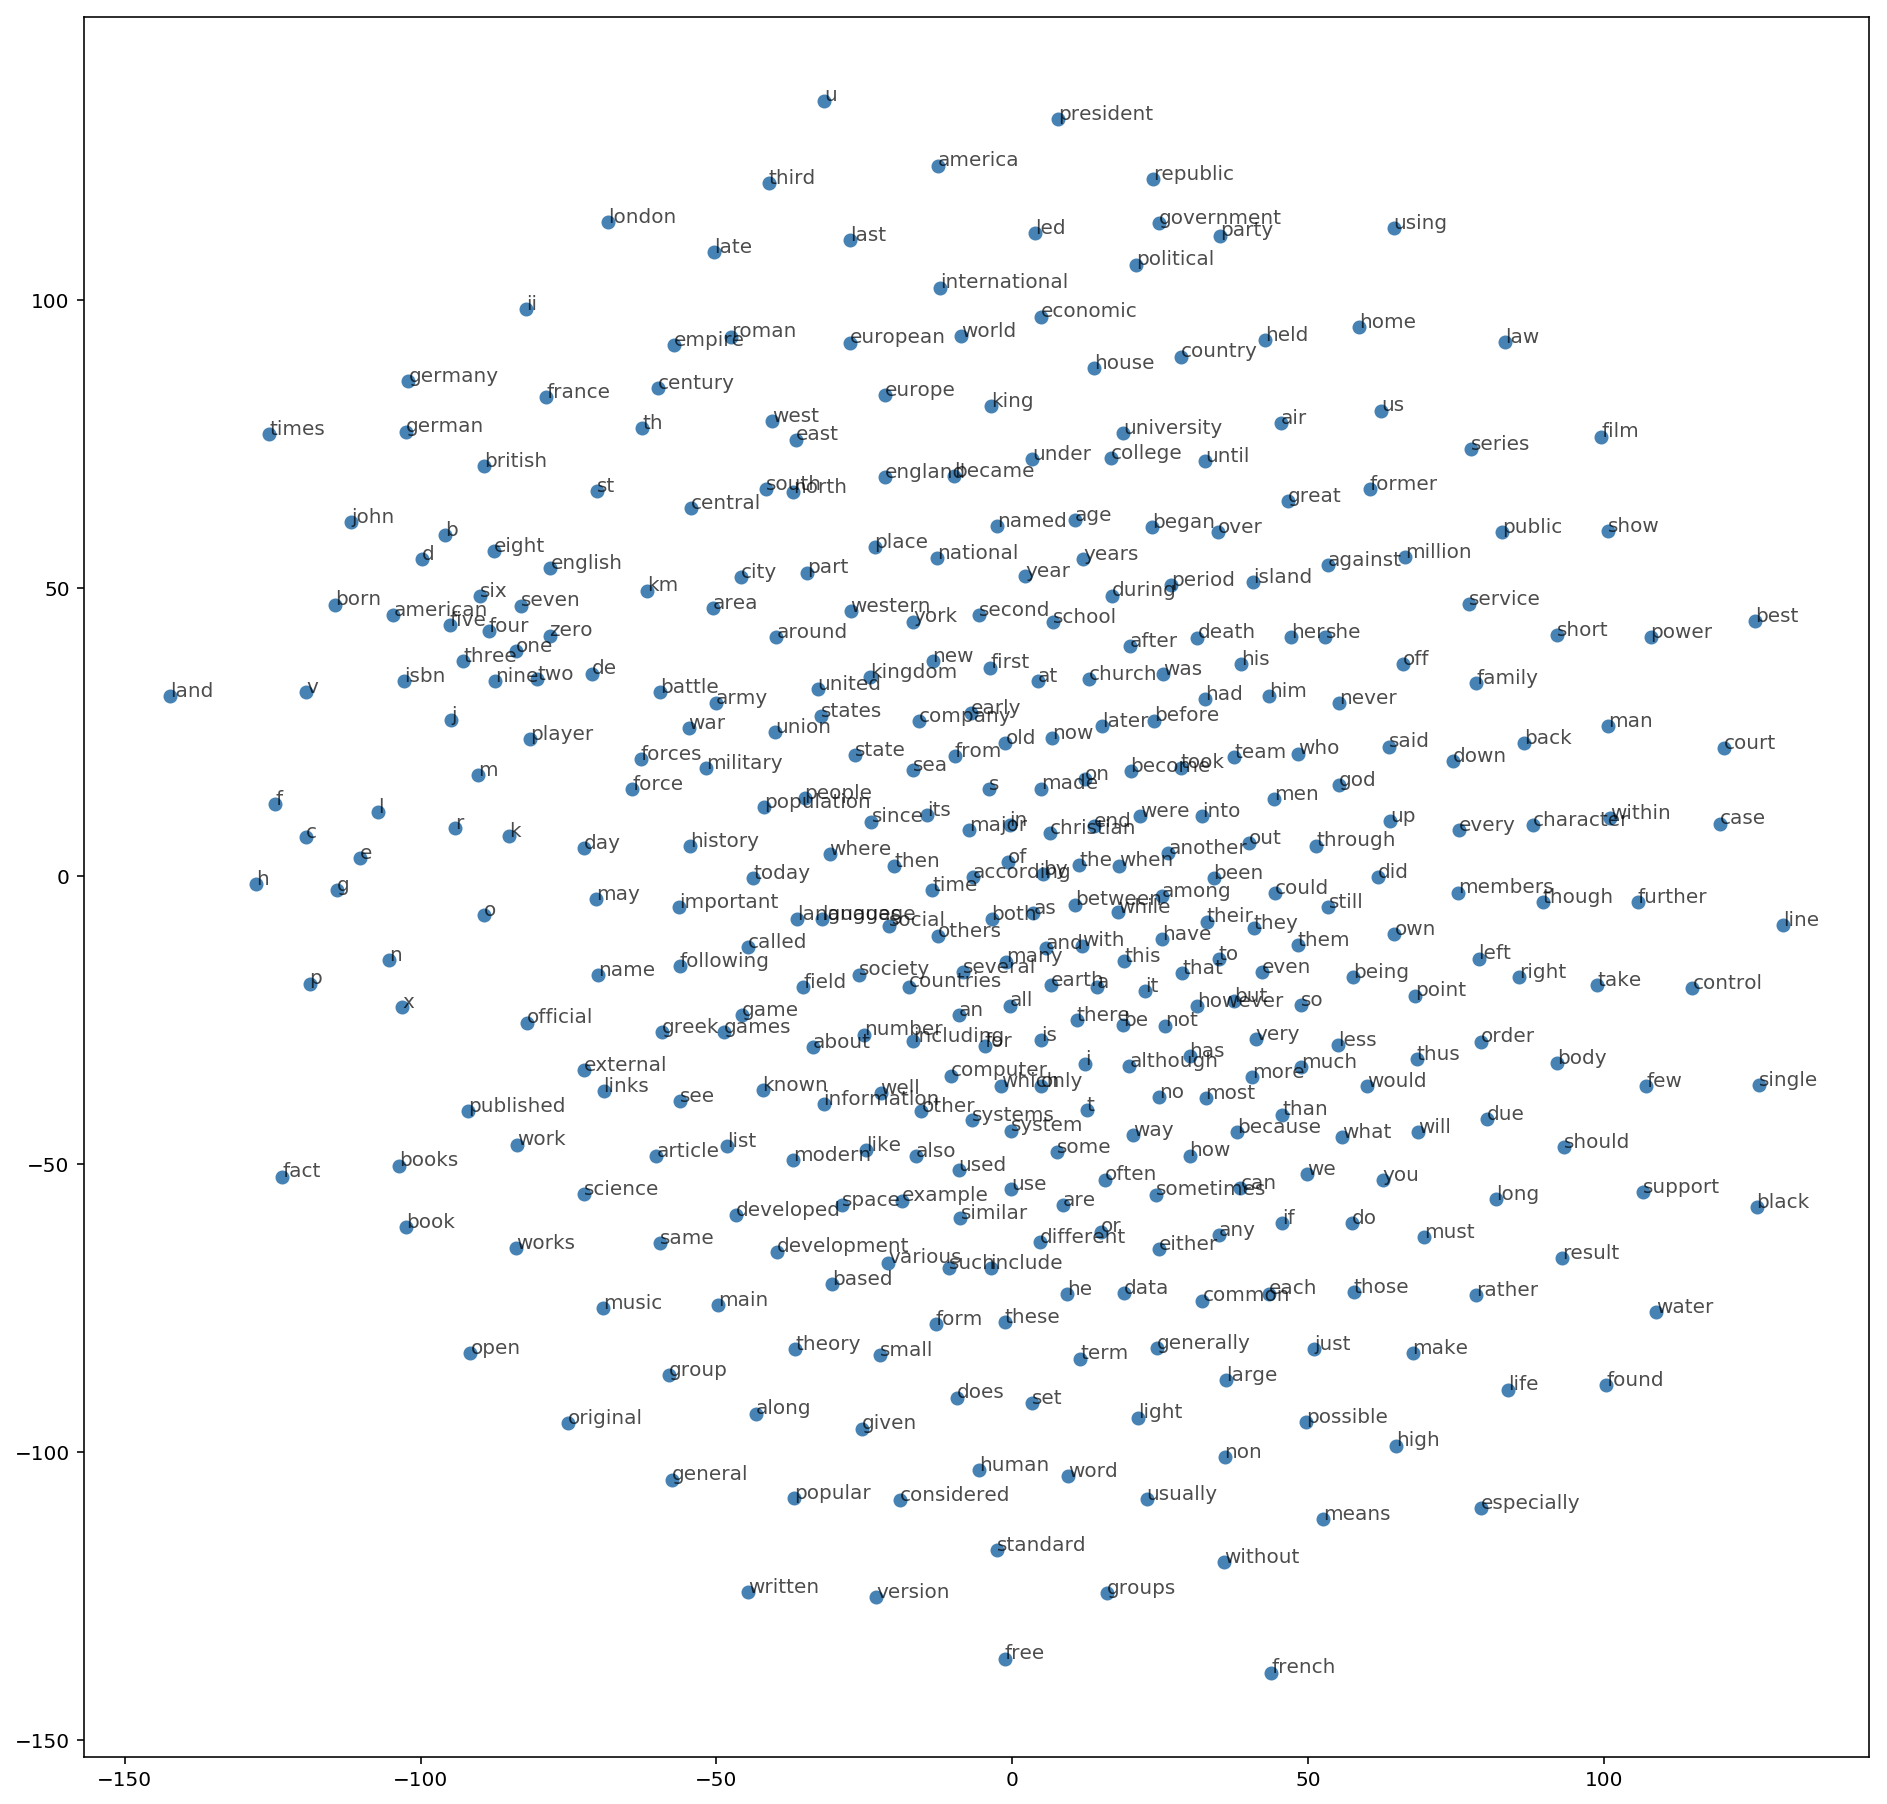

In [18]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [19]:
from workspace_utils import active_session
with active_session():
    print('finish')

finish


```python

```